In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import json
import os
import glob
import seaborn as sns

In [3]:
dataset = []
with open('../data/clusters/bias_dataset_bfcl_format.jsonl') as f:
    data = [json.loads(line) for line in f]
print(data[0]['function'])

[{'name': 'goapis_geocoding_api.geocding', 'description': "Geocoding is the process of converting a physical address into geographic coordinates, such as latitude and longitude. It allows for the identification of a specific location on the Earth's surface, making it possible to map and analyze data spatially", 'parameters': {'type': 'object', 'properties': {'lat': {'type': 'string', 'description': ''}, 'long': {'type': 'string', 'description': ''}}, 'required': []}}, {'name': 'geocode___forward_and_reverse.forward_geocode', 'description': 'Get lat,lng coordinates from an address.', 'parameters': {'type': 'object', 'properties': {'address': {'type': 'string', 'description': ''}}, 'required': ['address']}}, {'name': 'geolocate.get_coordinates', 'description': 'GET request to the "/geocode" endpoint with an "address" parameter containing the address or place you want to geocode', 'parameters': {'type': 'object', 'properties': {'address': {'type': 'string', 'description': ''}}, 'required'

In [4]:

def plot_called_tool_index_distribution(df, attempt_number, target_tool_index=None, ax=None):
    """
    Plots the distribution of called_tool_index for a given attempt number in the dataframe.
    
    Parameters:
        df (pd.DataFrame): The dataframe containing the data.
        attempt_number (int): The attempt number to filter on.
        target_tool_index (int, optional): The index to highlight in the plot. If None, will use the first row's target_tool_index if available.
        title_prefix (str): Prefix for the plot title.
        ax (matplotlib.axes.Axes, optional): The axis to plot on. If None, creates a new figure.
    
    Returns:
        fig, ax: The figure and axis objects if ax=None, otherwise just the axis
    """
    # Filter for the specified attempt
    filtered = df[df['attempt'] == attempt_number]
    if filtered.empty:
        print(f"No data for attempt {attempt_number}")
        return None, None if ax is None else None

    # Determine target_tool_index if not provided
    if target_tool_index is None and 'target_tool_index' in filtered.columns:
        target_tool_index = filtered['target_tool_index'].iloc[0] if not filtered['target_tool_index'].isnull().all() else None
    elif target_tool_index is None and 'target_tool' in filtered.columns:
        target_tool_index = filtered['target_tool'].iloc[0]

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = None

    # Ensure all bars (0 to 4) are plotted, even if missing in value_counts
    all_indices = list(range(5))
    value_counts = filtered['called_tool_index'].value_counts().sort_index()
    # Reindex to ensure all indices 0-4 are present, fill missing with 0
    value_counts = value_counts.reindex(all_indices, fill_value=0)

    # Prepare bar colors: highlight target_tool_index in a different color
    bar_colors = []
    for idx in value_counts.index:
        if target_tool_index is not None and idx == target_tool_index:
            bar_colors.append('orange')  # Highlight color for target_tool
        else:
            bar_colors.append('lightblue') # Default color

    ax.bar(value_counts.index, value_counts.values, edgecolor='black', color=bar_colors)
    ax.set_xlabel('Called Tool Index')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Attempt {attempt_number}')
    ax.set_xticks(value_counts.index)
    ax.set_ylim(0, 100)  # Set y-axis from 0 to 100
    
    return (fig, ax) if ax is None else ax


In [5]:
def safe_index(ls, item):
    try:
        return ls.index(item)
    except ValueError:
        return None

def plot_file(file_path):
    df = pd.read_json(file_path, lines=True)
    target_tool = df['target_tool_index'][0]
    cluster_id = df['cluster_id'][0]
    print(target_tool)
    # find index of first called tool
    df['called_tool_index'] = df.apply(
        lambda row: safe_index(list(map(lambda x: x['function']['name'], row['tools_provided'])), row['called_tool_names'][0] if row['called_tool_names'] and len(row['called_tool_names']) > 0 else -1),
        axis=1
    )

    # Get total number of unique attempts
    num_attempts = df['attempt'].nunique()
    num_rows = (num_attempts + 4) // 5  # Round up division to determine number of rows needed

    # Create a grid with enough subplots for all attempts
    _, axes = plt.subplots(num_rows, 5, figsize=(24, 5*num_rows), sharey=True)
    axes = axes.flatten()

    # Plot each attempt
    for i, attempt_number in enumerate(sorted(df['attempt'].unique())):
        plot_called_tool_index_distribution(df, attempt_number, ax=axes[i])

    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f'Qwen3 Distribution of Index of Called Tool for Cluster {cluster_id}; file: {file_path}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def get_selection_rates(file_path):
    df = pd.read_json(file_path, lines=True)
    mean_selected = df.groupby('attempt')['target_tool_selected'].mean()
    return mean_selected

0


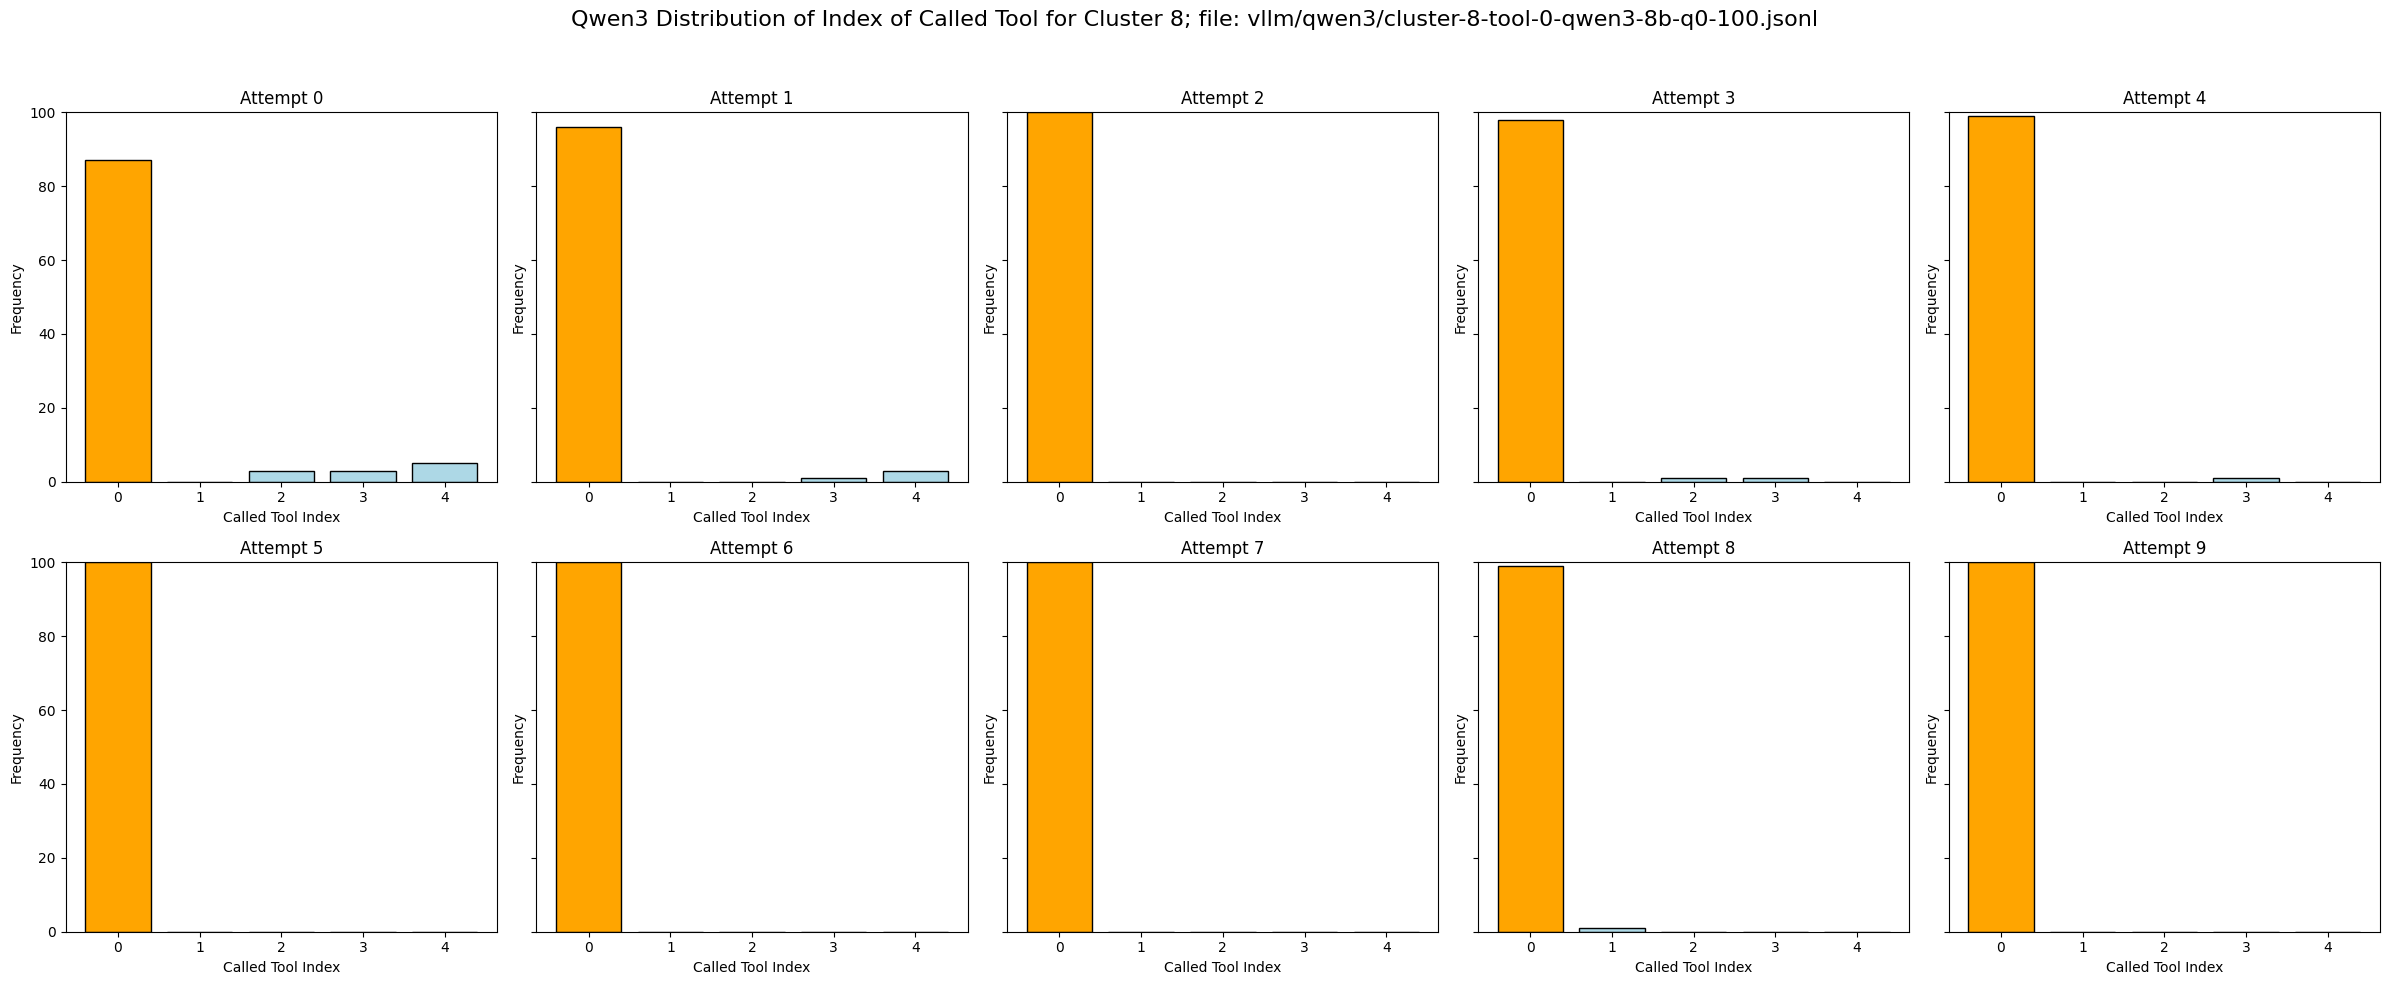

1


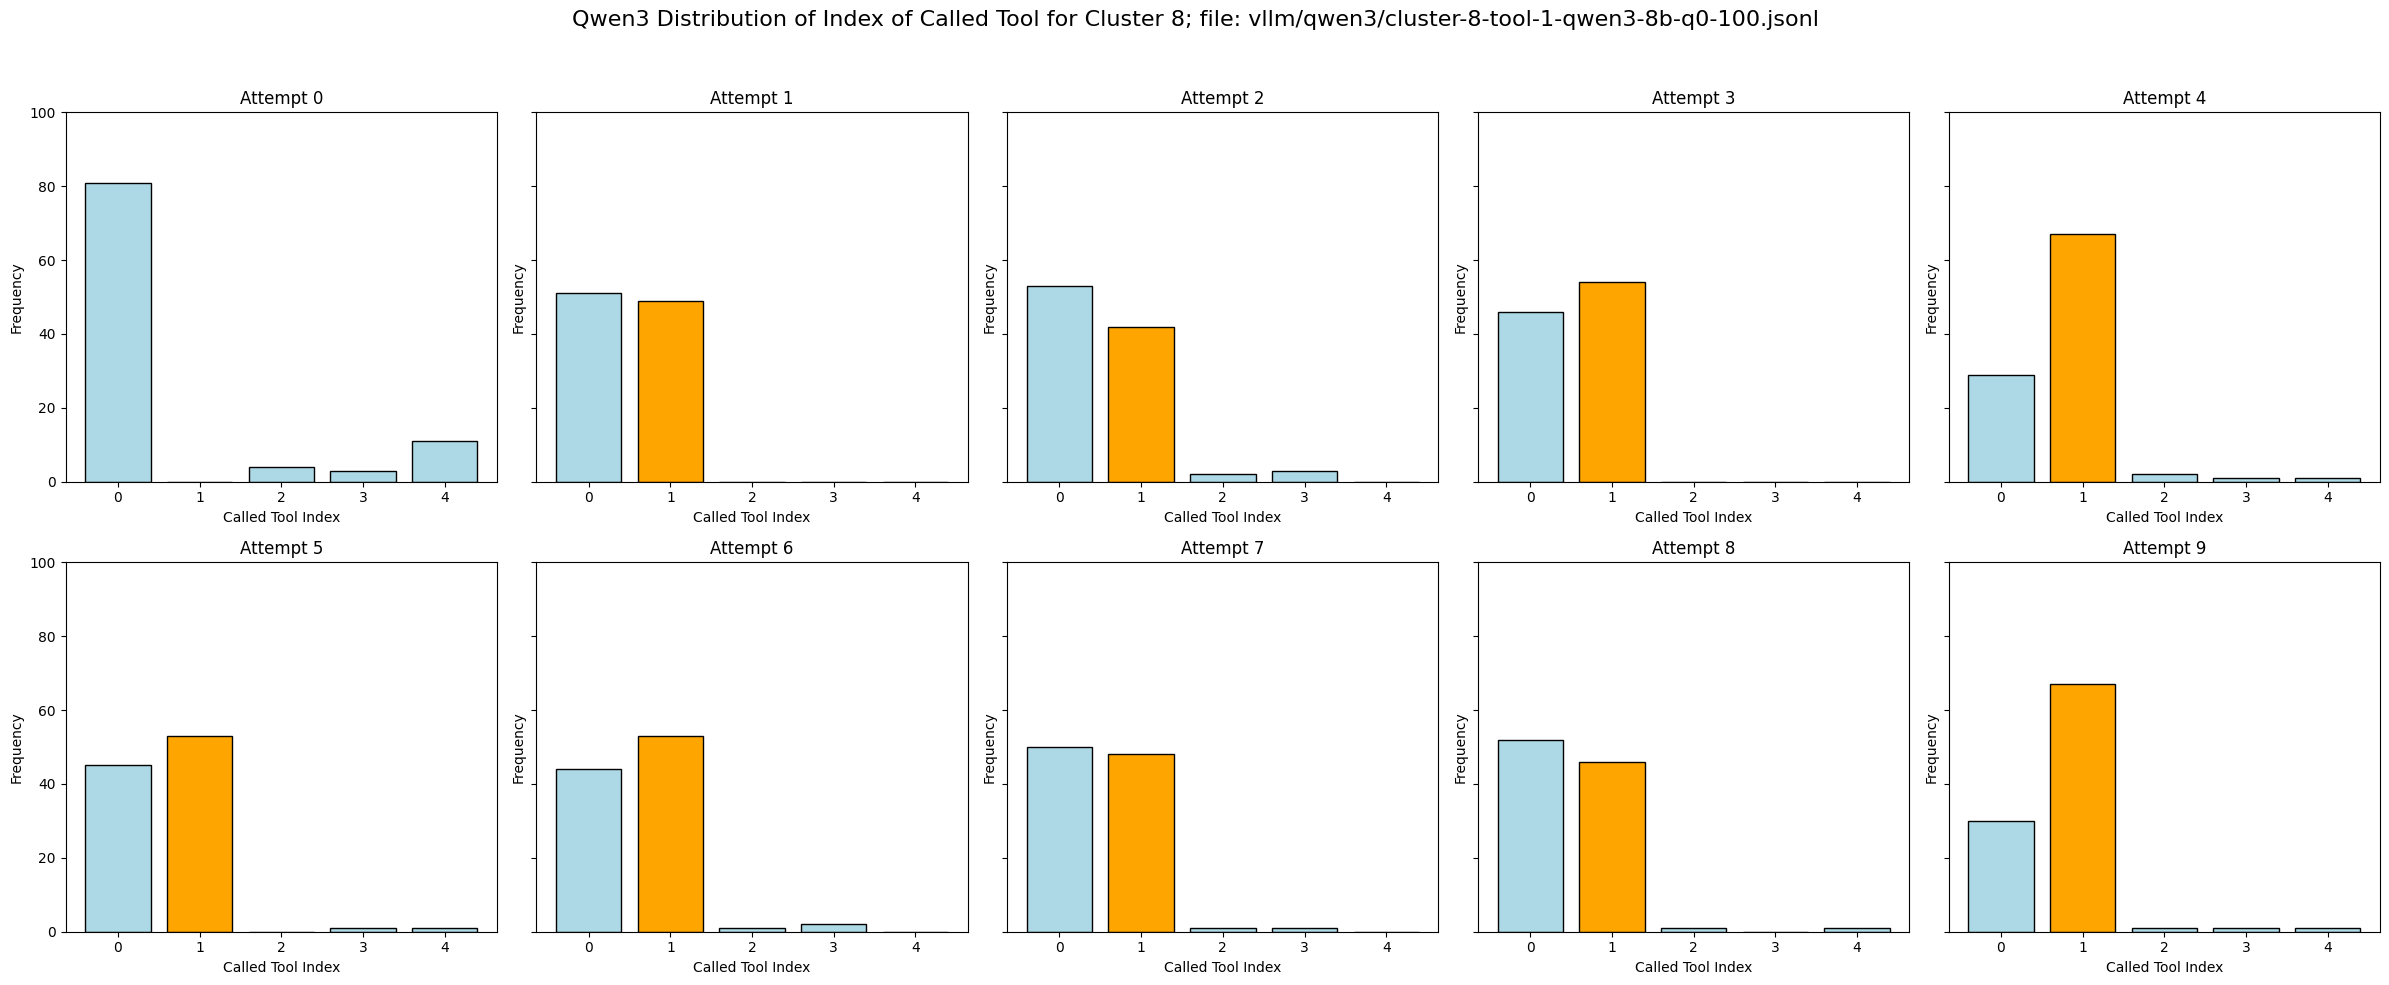

2


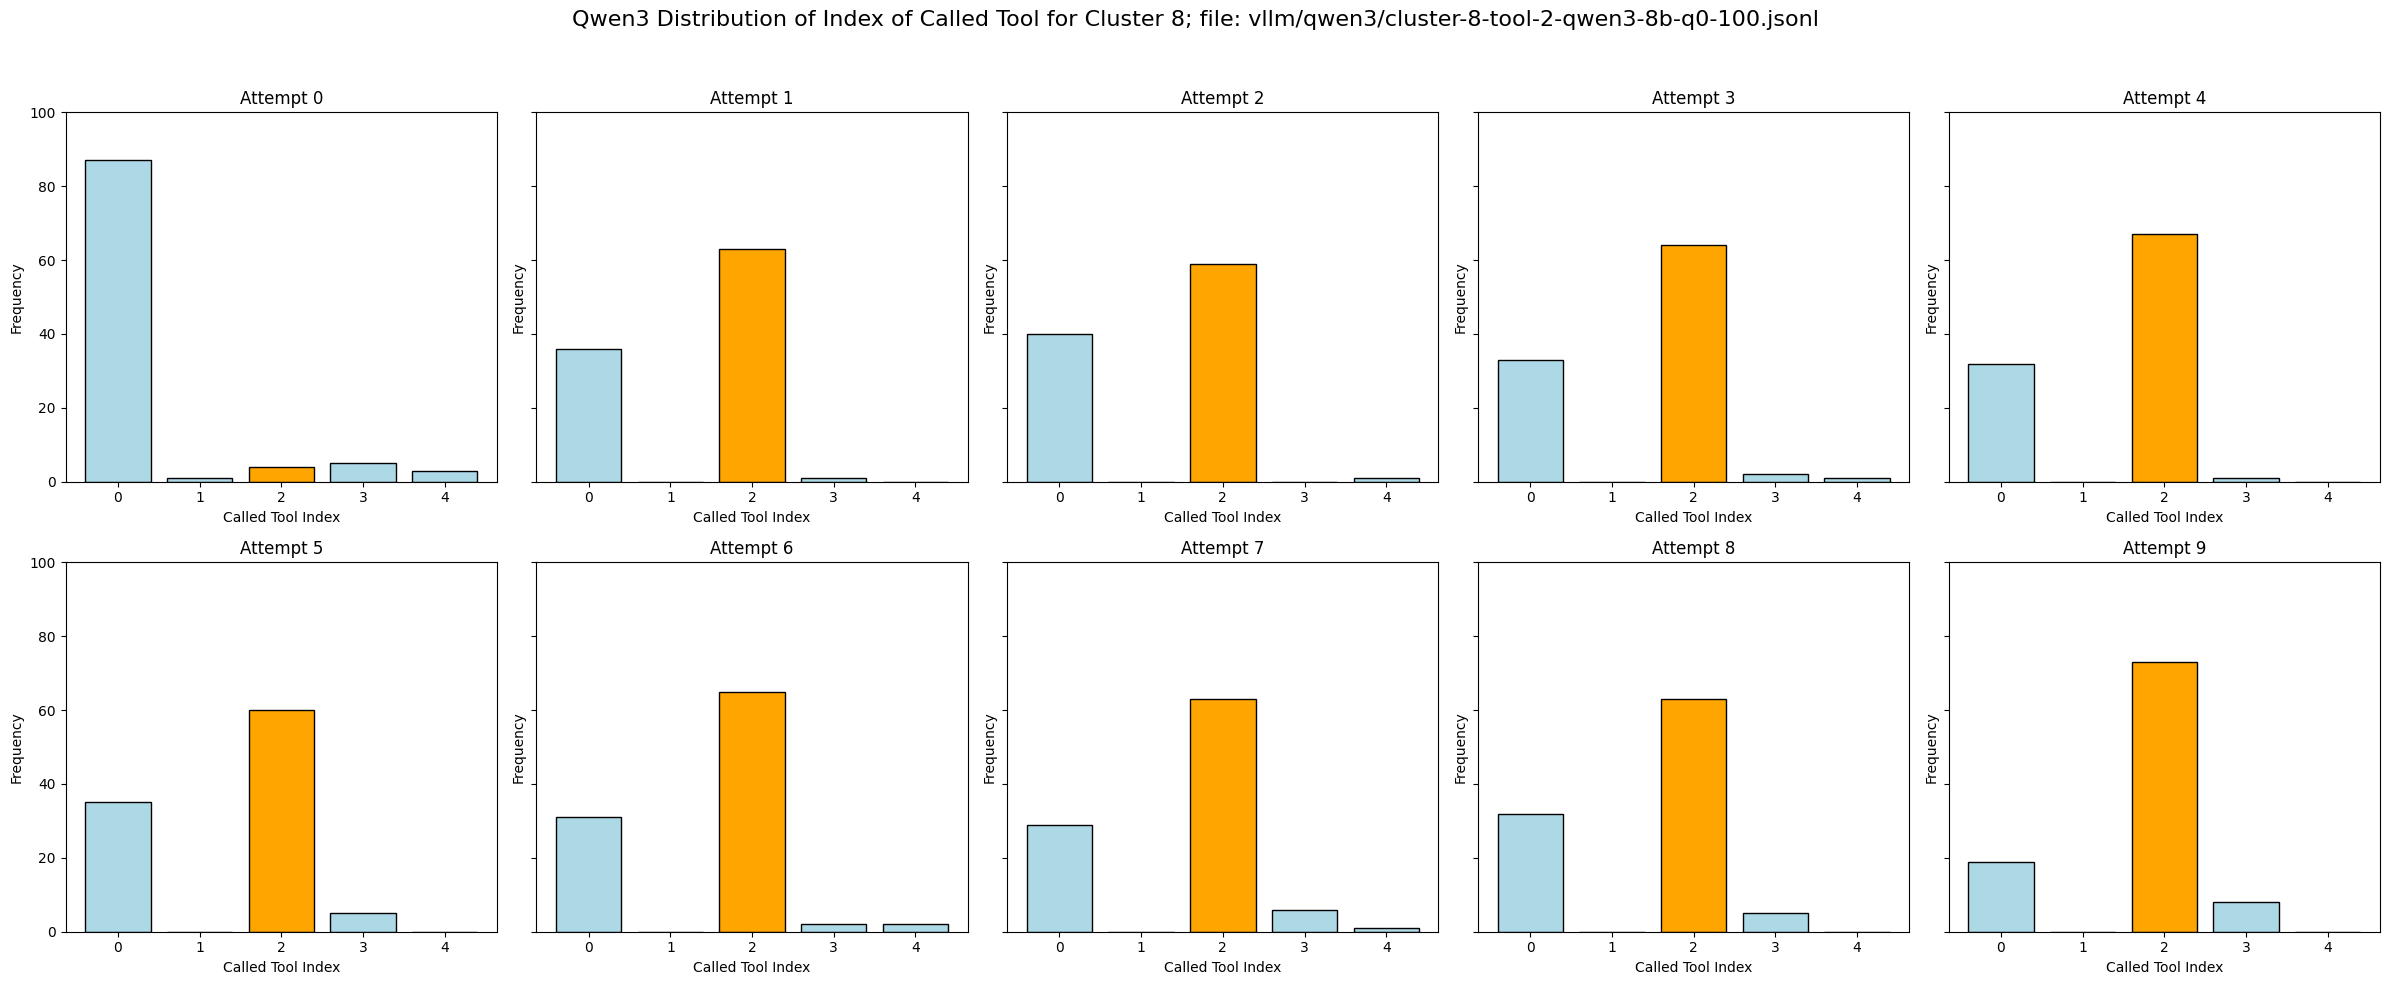

3


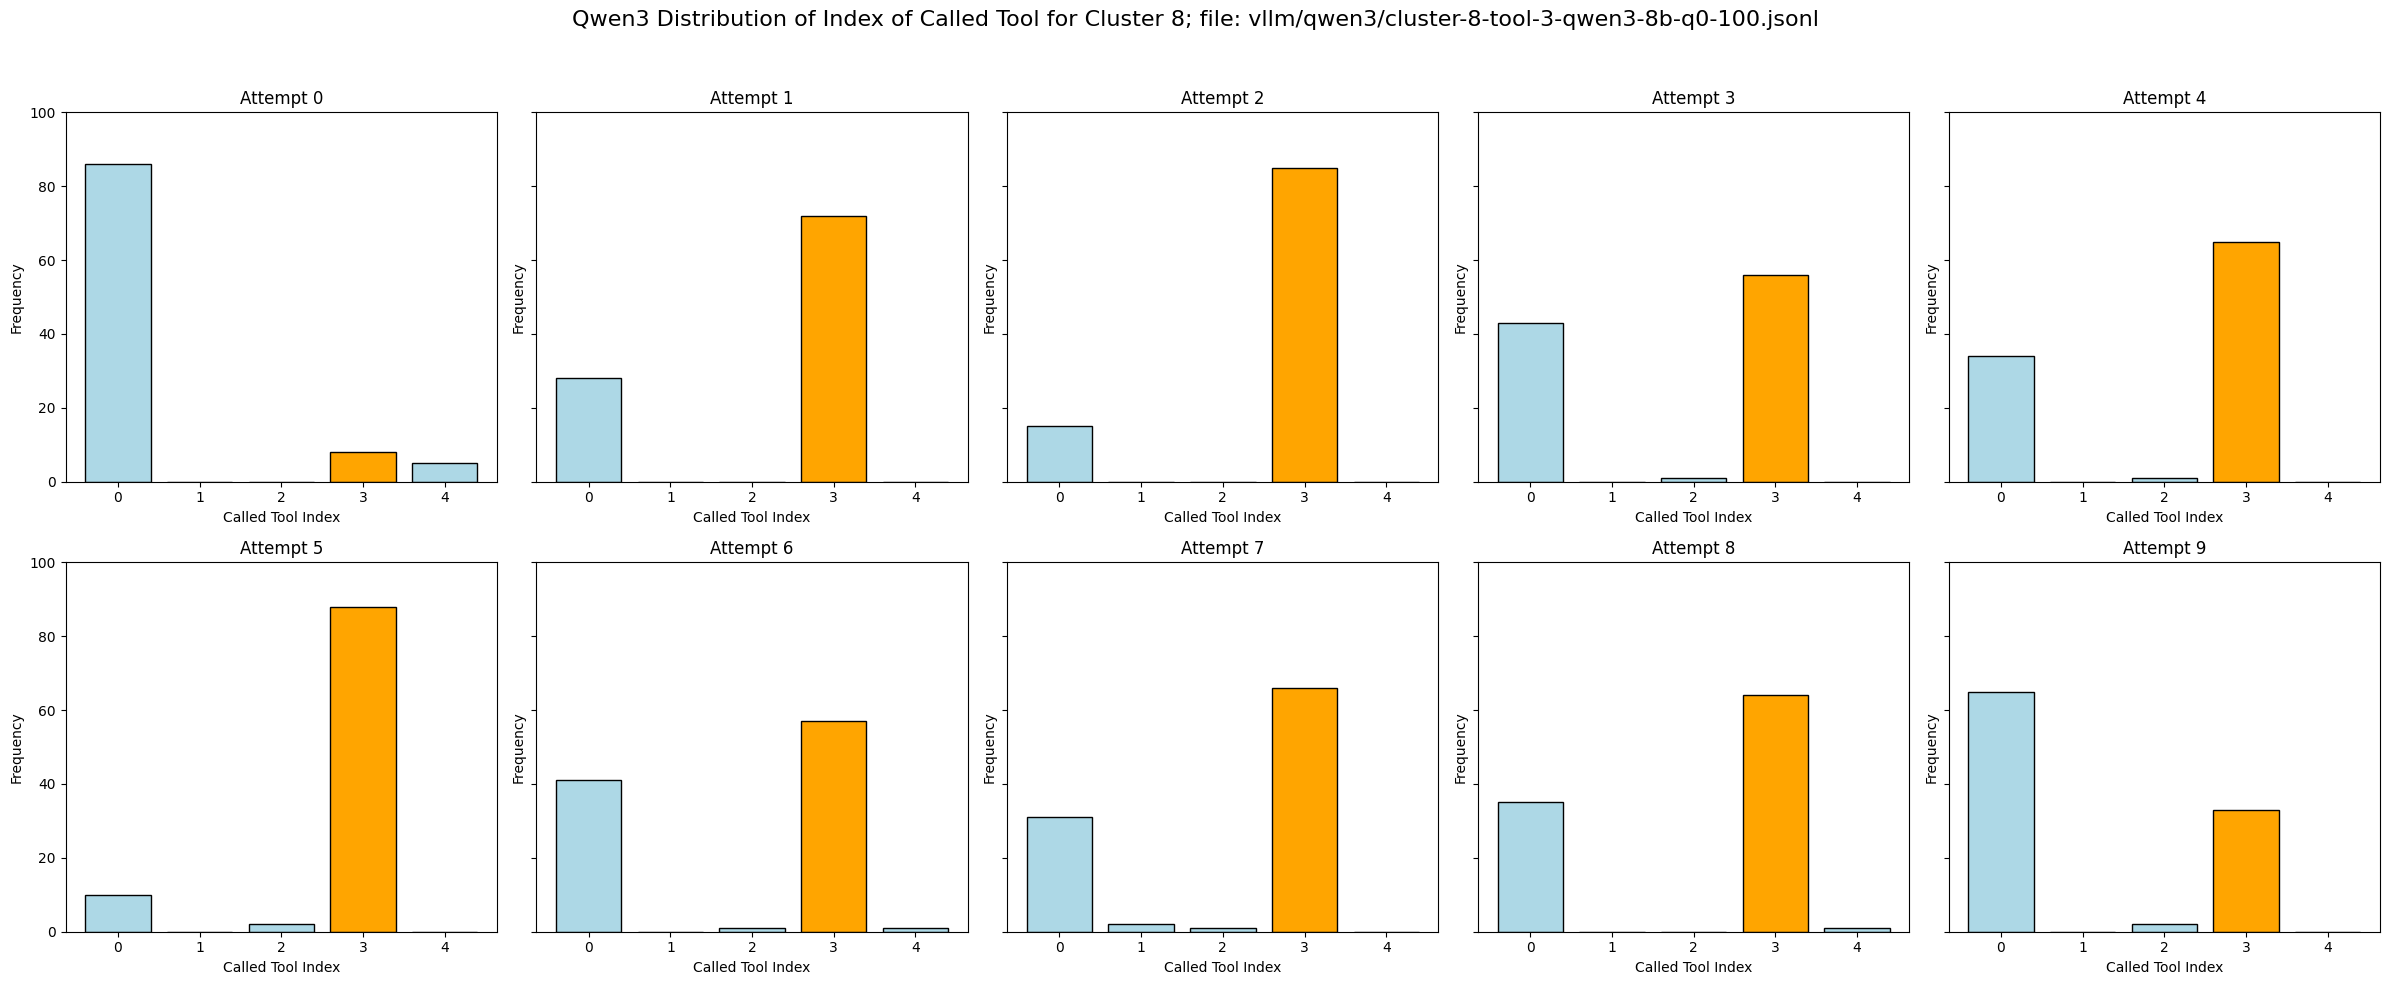

4


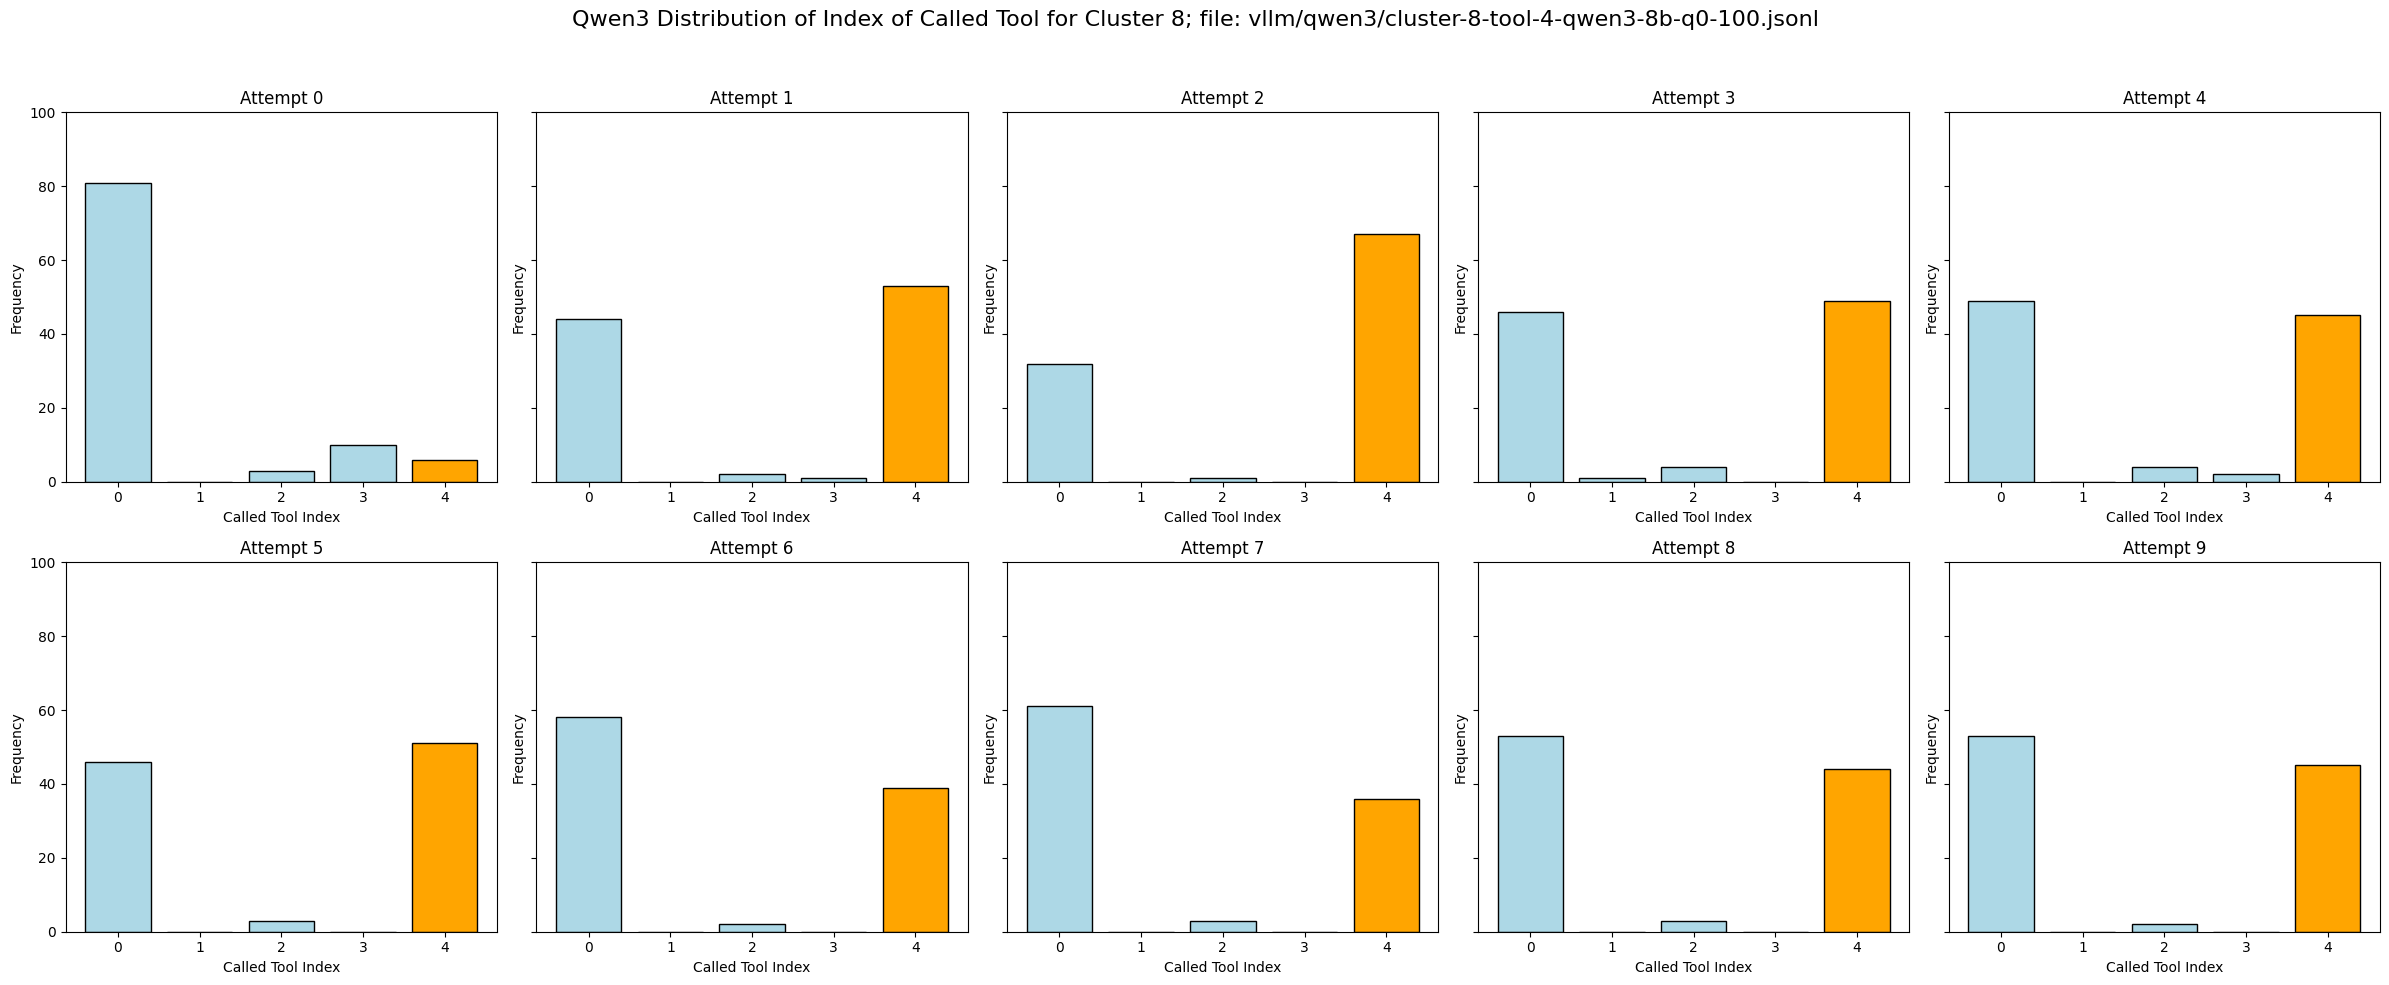

In [ ]:
model = 'qwen3'
server = 'vllm'
cluster_ids = [1,2,3,8,10]
# cluster_ids = [2,3]
BASE_DIR = f'{server}/{model}'

cluster_id = 8

for file in sorted(os.listdir(BASE_DIR)):
    if f'cluster-{cluster_id}-' in file and not file.endswith('improvement_history.jsonl'):
        # plot_file(f'{BASE_DIR}/{file}')
        pass

In [10]:
def get_best_and_last_selection_rates(dir, cluster_id,index):
    pattern = f'cluster-{cluster_id}-tool-{index}-*'
    files = glob.glob(os.path.join(dir, pattern))
    selection_rate = None

    original = None
    best = None
    last = None

    for i, file in enumerate(files):
        
        if not file.endswith('improvement_history.jsonl'):
            continue
        
        # every run should have 2 files, one for improvement history and one for selection rate
        if i > 1:
            break
        df = pd.read_json(file, lines=True)
        selection_rate = df['percent']
        original = selection_rate.iloc[0]
        best = selection_rate.iloc[1:].max()
        last = selection_rate.iloc[-1]
    return original, best, last

BASE_DIR = f'{server}/{model}'
print(get_best_and_last_selection_rates(BASE_DIR,8, 3))

(np.int64(8), np.int64(88), np.int64(33))


In [23]:
def get_dir_info(dir):
    args_path = os.path.join(dir, 'args.json')
    with open(args_path, 'r') as f:
        args = json.load(f)
    model = args.get('model')
    args['attacker_llm_model'] = args.get('attacker_llm_model') if args.get('attacker_llm_model') is not None else model
    args['defender_llm_model'] = args.get('defender_llm_model') if args.get('defender_llm_model') is not None else model
    return args


In [36]:
def collect_tool_selection_rates(dir, num_clusters=10):
    data = []
    for cluster_id in range(1, num_clusters+1):
        for tool_index in range(0, 5):
            try:
                original, best, last = get_best_and_last_selection_rates(dir, cluster_id, tool_index)
                if original is None:
                    continue
                data.append({
                    'Cluster ID': cluster_id,
                    'Tool Index': tool_index,
                    # 'Original Tool Name': tool_name,
                    'Original Selection Rate': original,
                    'Best Selection Rate': best,
                    'Improvement?': best > original,
                    # 'Last Selection Rate': last,

                })
            except Exception as e:
                print(f"Error: {e}")
                continue
    return pd.DataFrame(data)



def style_latex(df, args, dir='..'):
    server = args.get('server-type', '') 
    # trials where server isn't specified were run on ollama
    # this changed in a later version of the code, so I'm future-proofing
    if server == '':
        server = 'ollama'

    model = args['model']
    attacker = args['attacker_llm_model']
    defense = args['defense_mechanism']

    df_copy = df.copy()
    # overall improvement (guard if column missing)
    improvement_percentage = df_copy['Improvement?'].mean() if 'Improvement?' in df_copy.columns else 0.0

    out = []
    out.append('% Required packages: \\usepackage{longtable,booktabs,pifont,xcolor}')
    out.append(r'\begin{longtable}{@{}l@{}}')

    caption = f"Tool selection results for {model} on {server} with attacker {attacker} and defense {defense}. \\\\ \\textbf{{Overall Improvement: {improvement_percentage*100:.2f}\\%}}"
    out.append(r'\caption{' + caption + r'} \\')

    TITLE_TEXT = 'Attack Selection Rates for ' + model + ' on ' + server

    out.append(r'\toprule')
    # out.append(r'\centering')
    out.append(r'\multicolumn{1}{c}{\textbf{' + TITLE_TEXT + r'}} \\')

    out.append(r'\midrule')
    out.append(r'\endfirsthead')

    out.append(r'\toprule')
    # out.append(r'\centering')
    out.append(r'\multicolumn{1}{c}{\textbf{' + TITLE_TEXT + r'}} \\')

    out.append(r'\midrule')
    out.append(r'\endhead')

    out.append(r'\bottomrule')
    out.append(r'\endfoot')

    # iterate clusters in sorted order
    for cluster_id in sorted(df_copy['Cluster ID'].unique()):
        cluster_df = df_copy[df_copy['Cluster ID'] == cluster_id]
        if cluster_df.empty:
            continue

        cluster_lines = []

        if cluster_id != sorted(df_copy['Cluster ID'].unique())[0]:
            cluster_lines.append(r'\vspace{2ex}')


        # centered cluster title (over the full textwidth)
        cluster_lines.append(r'\noindent{\textbf{Cluster ' + str(cluster_id) + r'}}\\[0.8ex]')

        # nested tabular with vertical bars and hlines
        cluster_lines.append(r'\begin{tabular}{|c|c|c|c|} \hline')
        cluster_lines.append(r'\textbf{Tool Index} & \textbf{OSR} & \textbf{ BSR} & \textbf{Improvement?} \\ \hline')

        # safe formatting for numeric vs text values
        def fmt_val(x):
            if pd.isna(x):
                return 'N/A'
            if isinstance(x, (int, float)):
                return f"{x:.2f}\%"
            return str(x)

        for _, row in cluster_df.iterrows():
            ti = str(row['Tool Index'])
            orig = fmt_val(row['Original Selection Rate'])
            best = fmt_val(row['Best Selection Rate'])
            imp = r'\textcolor{green}{\ding{51}}' if row['Improvement?'] else r'\textcolor{red}{\ding{55}}'
            cluster_lines.append(ti + ' & ' + orig + ' & ' + best + ' & ' + imp + r' \\ \hline')

        cluster_lines.append(r'\end{tabular}')

        # wrap the whole cluster block in a minipage (unbreakable)
        block = r'\begin{minipage}{\textwidth}' + '\n' + r'\centering'+ '\n'.join(cluster_lines) + '\n' + r'\end{minipage}'
        out.append(block + r'\\[2ex]')  # small vertical gap between clusters

    out.append(r'\end{longtable}')

    output_path = f'{dir}/figures/{model}_{attacker}_{defense}_{server}_tool_selection_rates.tex'
    # create dir

    if not os.path.exists(f'{dir}/figures'):
        os.mkdir(f'{dir}/figures')
    
    with open(output_path, 'w') as f:
        f.write('\n'.join(out))



    



In [ ]:
def plot_selection_rate_distributions_smooth(df: pd.DataFrame, model: str) -> None:
    # Check if the required columns are in the DataFrame.
    required_columns = ['Original Selection Rate', 'Best Selection Rate']
    if not all(col in df.columns for col in required_columns):
        print("Error: DataFrame must contain both 'Original Selection Rate' and 'Best Selection Rate' columns.")
        return

    # Set a nice style for the plot using Seaborn
    sns.set_style("whitegrid")
    
    # Create the figure and axes for the plot
    plt.figure(figsize=(10, 6))
    
    # Plot the distribution of the original selection rate with a smooth KDE curve
    sns.kdeplot(
        data=df, 
        x='Original Selection Rate', 
        fill=True, 
        label='Original Selection Rate', 
        color='blue', 
        alpha=0.6,
        bw_adjust=0.5, # A value below 1 makes the plot less smooth, above 1 makes it smoother,
        clip=(0,100),
    )
    
    # Plot the distribution of the best selection rate
    sns.kdeplot(
        data=df, 
        x='Best Selection Rate', 
        fill=True, 
        label='Best Selection Rate', 
        color='orange', 
        alpha=0.6,
        bw_adjust=0.5,
        clip=(0,100),
    )
    
    # Add titles and labels for clarity
    plt.title(f'Distribution of Selection Rates for {model}', fontsize=16, fontweight='bold')
    plt.xlabel('Selection Rate', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    # Add a legend to differentiate the plots
    plt.legend(title='Rate Type', fontsize=10)
    
    # Ensure the layout is tight to prevent labels from being cut off
    plt.tight_layout()
    
    # Display the final plot
    plt.show()

def plot_selection_rate_distributions(df: pd.DataFrame, additional_title: str) -> None:
    # Check if the required columns are in the DataFrame.
    required_columns = ['Original Selection Rate', 'Best Selection Rate']
    if not all(col in df.columns for col in required_columns):
        print("Error: DataFrame must contain both 'Original Selection Rate' and 'Best Selection Rate' columns.")
        return

    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 7))
    
    # To plot both histograms on the same axes, we first need to melt the DataFrame
    # so that the column names become a new 'variable' column and the values are in a 'value' column.
    melted_df = df.melt(value_vars=required_columns, var_name='Selection Rate Type', value_name='Selection Rate')

    # Plot the histogram using sns.histplot. The 'hue' parameter plots a separate
    # histogram for each category in 'Selection Rate Type'.
    sns.histplot(
        data=melted_df,
        x='Selection Rate',
        hue='Selection Rate Type',
        multiple='dodge',  # This plots the bars side-by-side for easy comparison
        
        palette={'Original Selection Rate': 'blue', 'Best Selection Rate': 'orange'},
        bins=20,           # You can adjust the number of bins as needed
        stat='density'     # 'density' normalizes the counts to show distribution shape
    )
    
    # Add titles and labels for clarity
    plt.title(f'Distribution of Selection Rates: {additional_title}', fontsize=16, fontweight='bold')
    plt.xlabel('Selection Rate', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    # Ensure the layout is tight to prevent labels from being cut off
    plt.tight_layout()
    
    # Display the final plot
    plt.show()

In [53]:
def plot_best_success_rate_boxplots_from_dict(model_dfs: dict[str, pd.DataFrame], title: str) -> None:

    # Check if the dictionary is empty.
    if not model_dfs:
        print("Error: The input dictionary is empty.")
        return

    # Prepare a list to hold the reshaped data for plotting
    all_data = []

    # Iterate through the dictionary to combine and format the data
    for model_name, df in model_dfs.items():
        # Ensure the DataFrame has data and rename the column for consistency
        if not df.empty:
            df_copy = df.copy()
            print(df_copy.columns)
            df_copy = df_copy[['Best Selection Rate']]
            df_copy['Model'] = model_name
            all_data.append(df_copy)
        
    
    # Check if any data was collected before trying to concatenate
    if not all_data:
        print("Error: No valid data found in the provided DataFrames.")
        return

    # Concatenate all the reshaped DataFrames into a single one for plotting
    combined_df = pd.concat(all_data, ignore_index=True)

    # Set a nice style for the plot using Seaborn
    sns.set_style("whitegrid")
    
    # Create the figure and axes for the plot
    plt.figure(figsize=(12, 7))

    # Create the boxplot from the combined DataFrame
    sns.boxplot(x='Model', y='Best Selection Rate', data=combined_df, palette='pastel')

    # Add titles and labels for clarity
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('Best Selection Rate', fontsize=12)
    
    # Ensure the layout is tight to prevent labels from being cut off
    plt.tight_layout()
    
    # Display the final plot
    plt.show()

Index(['Cluster ID', 'Tool Index', 'Original Selection Rate',
       'Best Selection Rate', 'Improvement?'],
      dtype='object')
0.84


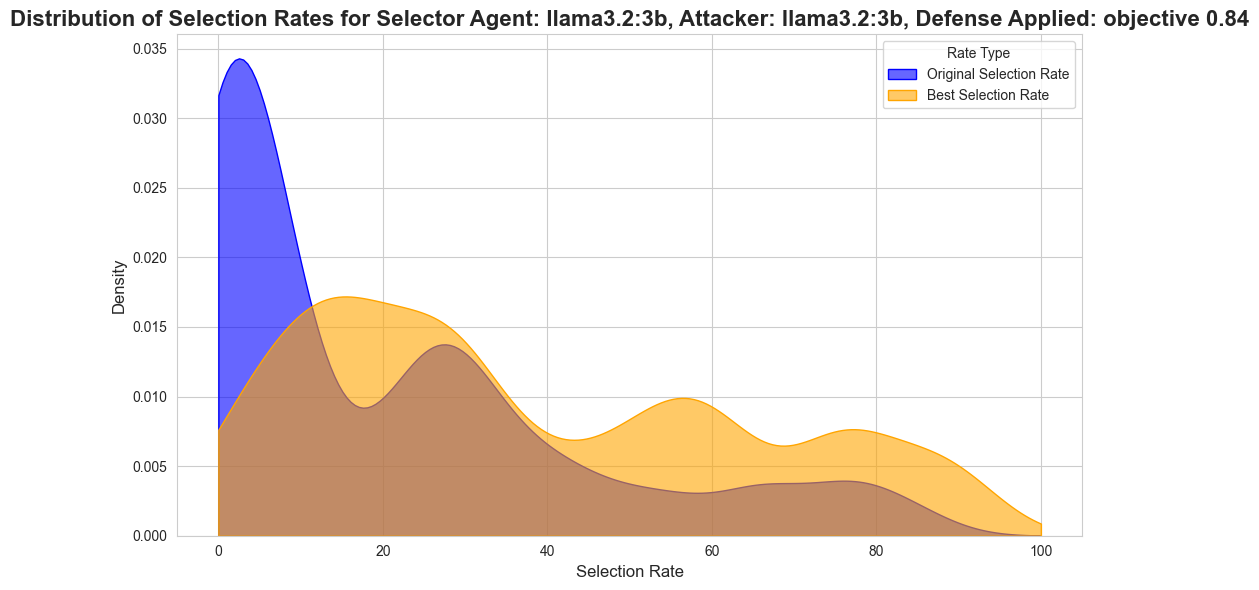

0.82


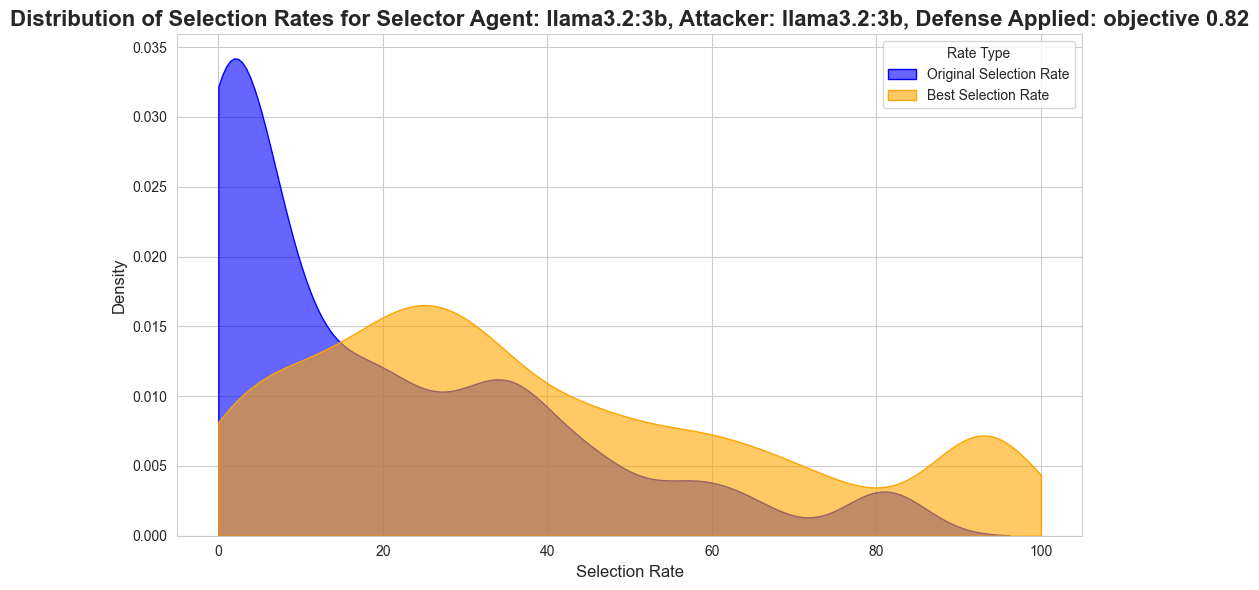

0.88


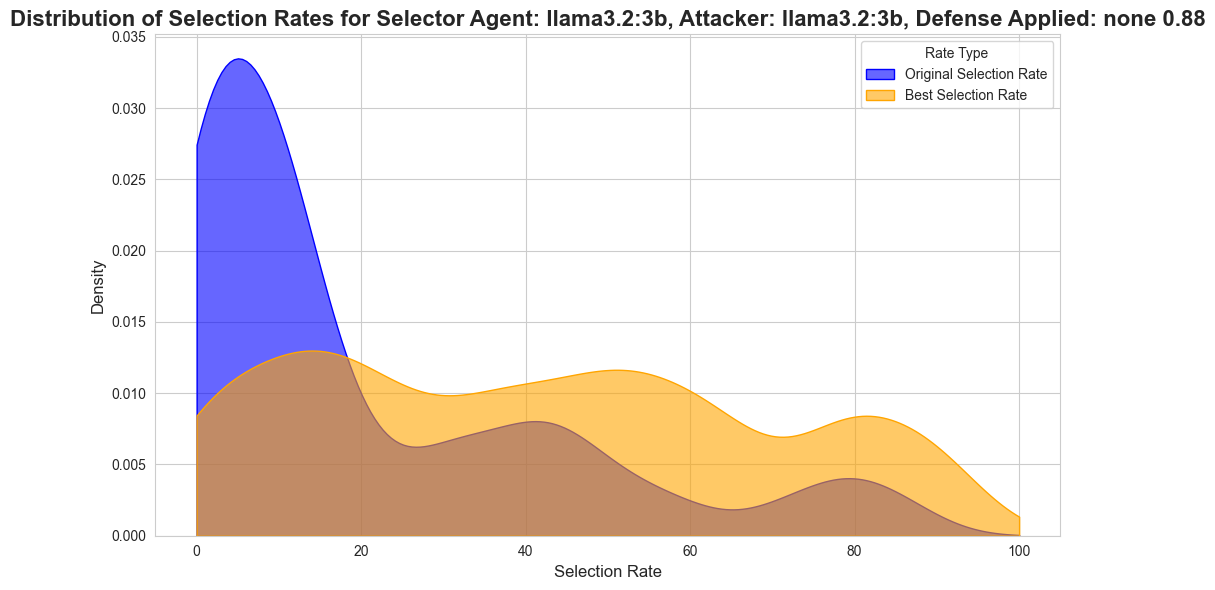

In [55]:
# Example usage:
df_tools = collect_tool_selection_rates(BASE_DIR, num_clusters=10)
# display(df_tools)
print(df_tools.columns)


PATH = "ollama/llama3.2_3b"
model_dfs = {}
for dir in os.listdir(PATH):
    full_path = os.path.join(PATH, dir)
    args = get_dir_info(full_path)
    df_tools = collect_tool_selection_rates(os.path.join(PATH, dir), num_clusters=10)
    mean_improved = df_tools['Improvement?'].mean()
    print(df_tools['Improvement?'].mean())
    info_string = f"Selector Agent: {args['model']}, Attacker: {args['attacker_llm_model']}, Defense Applied: {args['defense_mechanism']} {mean_improved}"
    model_dfs[info_string] = df_tools
    plot_selection_rate_distributions_smooth(df_tools, info_string)
    style_latex(df_tools, args, full_path)

Index(['Cluster ID', 'Tool Index', 'Original Selection Rate',
       'Best Selection Rate', 'Improvement?'],
      dtype='object')
Index(['Cluster ID', 'Tool Index', 'Original Selection Rate',
       'Best Selection Rate', 'Improvement?'],
      dtype='object')


/var/folders/c5/4sx9zv4s56sc2jwhq0rhlth80000gn/T/ipykernel_6559/1916893174.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='Best Selection Rate', data=combined_df, palette='pastel')


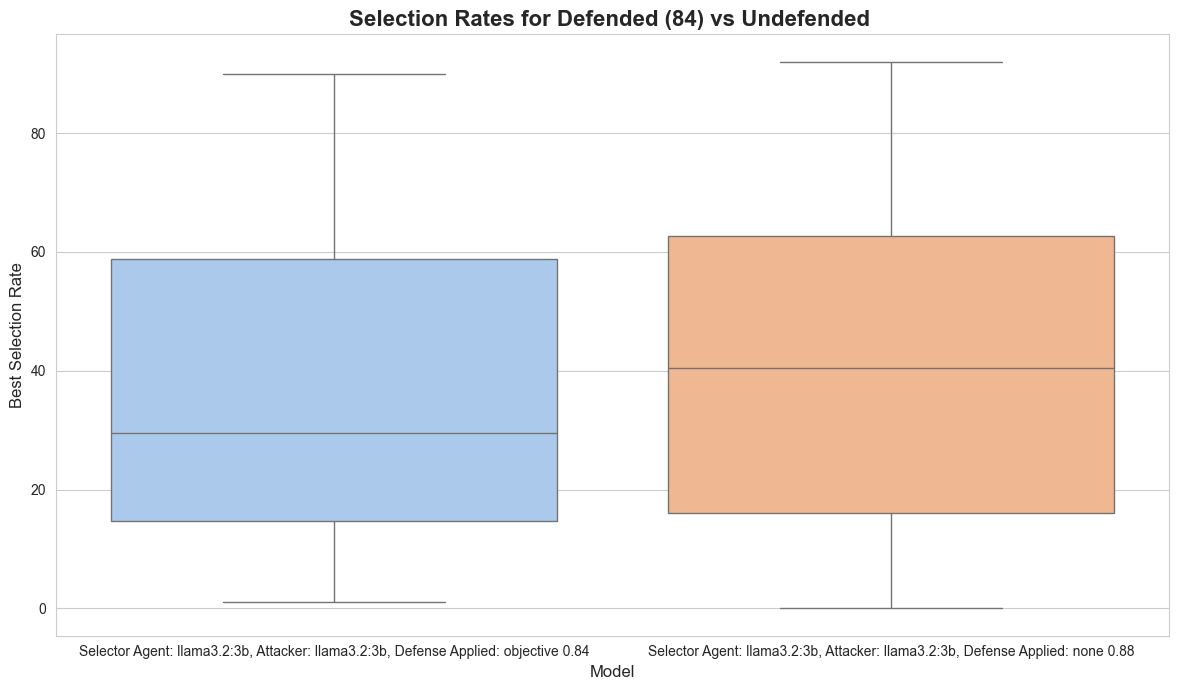

Index(['Cluster ID', 'Tool Index', 'Original Selection Rate',
       'Best Selection Rate', 'Improvement?'],
      dtype='object')
Index(['Cluster ID', 'Tool Index', 'Original Selection Rate',
       'Best Selection Rate', 'Improvement?'],
      dtype='object')


/var/folders/c5/4sx9zv4s56sc2jwhq0rhlth80000gn/T/ipykernel_6559/1916893174.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='Best Selection Rate', data=combined_df, palette='pastel')


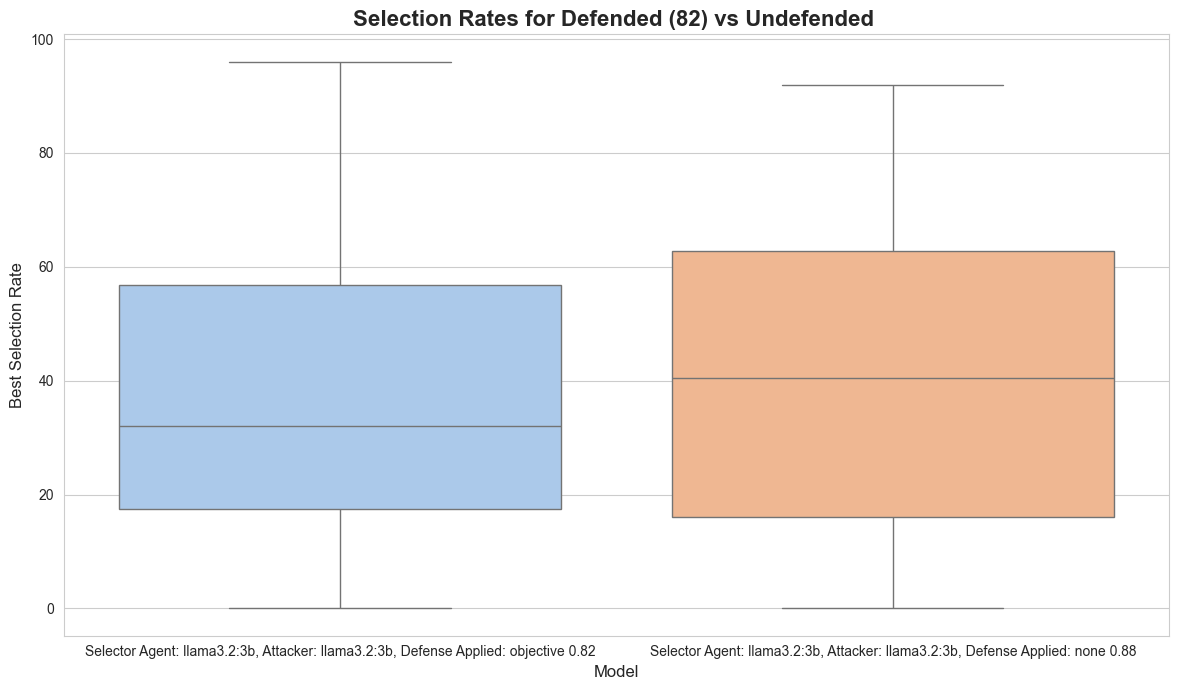

In [57]:
filtered_model_dfs = {k: v for k, v in model_dfs.items() if "88" in k or "84" in k}
plot_best_success_rate_boxplots_from_dict(filtered_model_dfs, 'Selection Rates for Defended (84) vs Undefended ')

filtered_model_dfs = {k: v for k, v in model_dfs.items() if "88" in k or "82" in k}
plot_best_success_rate_boxplots_from_dict(filtered_model_dfs, 'Selection Rates for Defended (82) vs Undefended ')

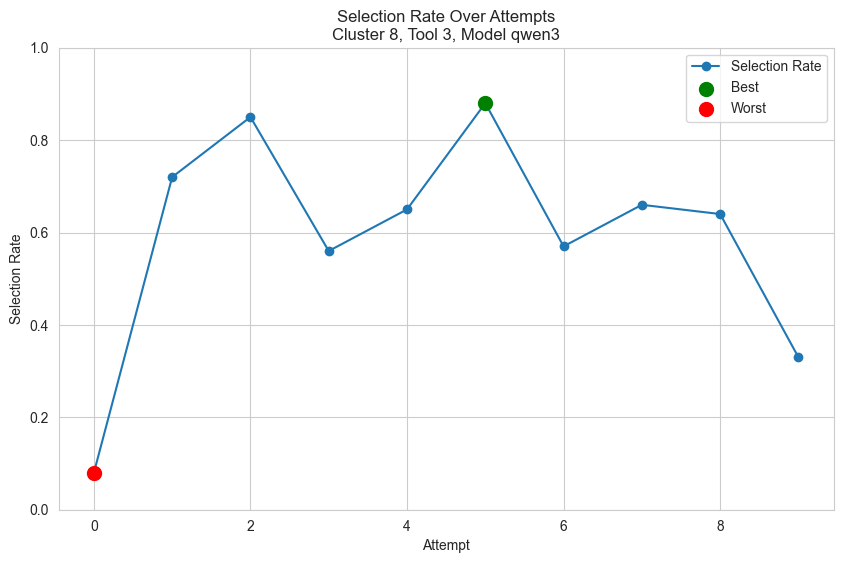

In [47]:
def plot_selection_rate_over_time(cluster_id, index, server, model):
    BASE_DIR = f'{server}/{model}'
    pattern = f'cluster-{cluster_id}-tool-{index}-*'
    files = glob.glob(os.path.join(BASE_DIR, pattern))
    selection_rate = None
    for i, file in enumerate(files):
        
        if file.endswith('improvement_history.jsonl'):
            continue

        if i > 1:
            print("Two files with the same setup. Weird")
            break

        selection_rate = get_selection_rates(file)
    # Plot selection rate over attempt, highlight best and worst performance
    attempts = np.arange(len(selection_rate))
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(attempts, selection_rate, marker='o', label='Selection Rate')

    # Highlight best (max) and worst (min) performance
    best_idx = np.argmax(selection_rate)
    worst_idx = np.argmin(selection_rate)
    ax.scatter([best_idx], [selection_rate[best_idx]], color='green', s=100, zorder=5, label='Best')
    ax.scatter([worst_idx], [selection_rate[worst_idx]], color='red', s=100, zorder=5, label='Worst')

    ax.set_xlabel('Attempt')
    ax.set_ylabel('Selection Rate')
    ax.set_ylim(0, 1)
    ax.set_title(f'Selection Rate Over Attempts\nCluster {cluster_id}, Tool {index}, Model {model}')
    ax.legend()
    plt.show()
        

plot_selection_rate_over_time(8, 3, 'vllm', 'qwen3')
